In [94]:
import json
from haralyzer import HarParser, HarPage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Extract websocket data from Har to JSON

In [126]:
class ProcHarData:
    
    def __init__(self,har_filename):
        self.harfile = har_filename
    
    def convHar2Json(self):
        with open(self.harfile, 'r') as f:
            har_parser = HarParser(json.loads(f.read()))

        data = har_parser.har_data
        ws_entries = []
        entries = []
        dict_data = {}
        for entry in har_parser.har_data["entries"]:
            if '_webSocketMessages' in entry.keys():
                ws_entries = entry['_webSocketMessages']
                break

        for ws_entry in ws_entries:    
            if ws_entry['data'].startswith("{"):
                data = json.loads(ws_entry['data'])
                if data['type'] == 3:
                    ws_entry['data'] = data
                    entries.append(ws_entry)
        dict_data['WS'] = entries
        json_filename = "data/data_" + datetime.now().strftime("%m-%d-%Y_%H:%M:%S") + ".json"
        with open(json_filename, 'w') as fp:
            json.dump(dict_data, fp)
        return json_filename


    def convJson2DF(self, json_filename=None):
        if json_filename:
            df = pd.read_json(json_filename)
        else:
            df = pd.read_json(self.convHar2Json())
        time = []
        duration = []
        for idx,row in df.iterrows():
            time.append(row['WS']['time'])
            durms = round(row['WS']['data']['data']['duration']/1000,2)
            duration.append(durms)
        df['DateTime'] = time
        df['TSDuration(ms)'] = duration
        df['DateTime'] = pd.to_datetime(df['DateTime'],unit='s')
        df = df.sort_values(by='DateTime')
        
        return df
    
    def plotTS(self,df1):
        
        fig, ax = plt.subplots(figsize=(12,5))
        meanDur = np.full(len(df1),df1.mean().values)
        df1.plot(figsize=(18,5),title='Tip Selection Duration(ms)',xlabel='Timesteps',ylabel='Duration(ns)',ax=ax)
        ax.plot(meanDur,'r')

        fig.show()

    TSDuration(ms)
0            42.78
1             2.44
2             9.47
3             4.47
4             3.34
..             ...
95            9.13
96            3.28
97            7.32
98            2.95
99            6.26

[100 rows x 1 columns]


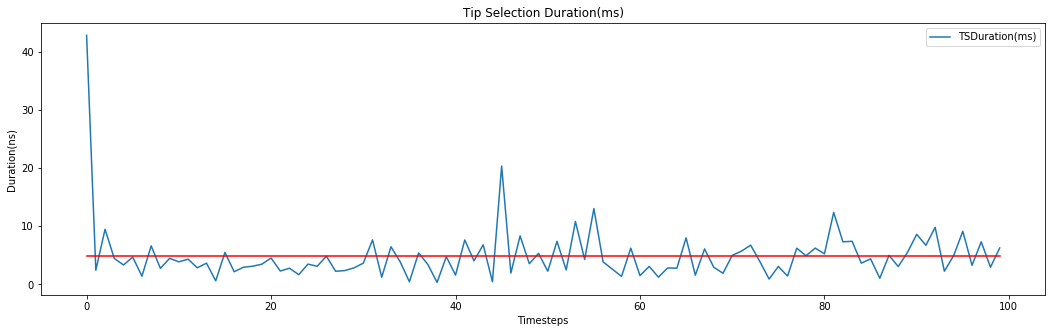

In [129]:
filename = 'data/10.2.8.177.har'
har = ProcHarData(filename)
df = har.convJson2DF()

df1 = df[['TSDuration(ms)']][:100]
print(df1)
har.plotTS(df1)

# Process locust perf data

In [138]:
class ProcLocustData:
    
    def __init__(self,locustdata_file,sheet_name):
        self.locustdata = locustdata_file
        self.task = sheet_name
    
    
    def load2DF(self):
        """
        load data and return statistics dataframe.
        -----------------------
        Parameters:
            sheet_name: string
                One of the sheet names ['prepareTransfer', 'sendTrytes','sendTransfer', 'ts', 'pow', 'bc']
        
        Returns:
            df_statics: DataFrame
                Statistics (mean values) dataframe of a specific task.
        -----------------------
        """
        df = pd.read_excel(self.locustdata, sheet_name=self.task)
        df = df.loc[(df['User Count'] % 10 == 0)]
        df_statics = df.groupby(by='User Count').mean()
        return df_statics
    
    
    def plotER(self):
        df = self.load2DF()
        
        fig=plt.figure()

        ax1 = df[['Total Average Response Time']].plot(marker='*',legend=False)
        ax2 = df['Requests/s'].plot(secondary_y=True, marker='o')
        ax1.set_ylabel('Mean Response Time(ms)')
        ax2.set_ylabel('Requests/s')

        handles,labels = [],['E[R]','$\lambda$']
        for ax in [ax1,ax2]:
            for h,_ in zip(*ax.get_legend_handles_labels()):
                handles.append(h)

        plt.legend(handles,labels,loc='upper left')

        plt.title('Mean Response Time against User Count ({})'.format(self.task))
        plt.show()

<Figure size 432x288 with 0 Axes>

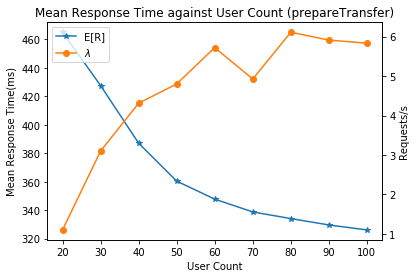

<Figure size 432x288 with 0 Axes>

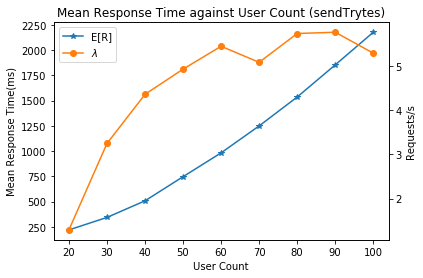

<Figure size 432x288 with 0 Axes>

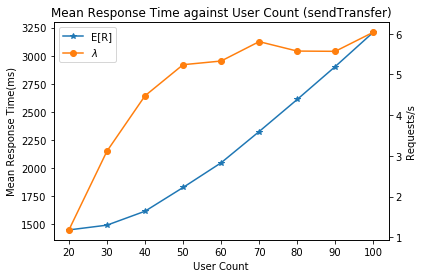

<Figure size 432x288 with 0 Axes>

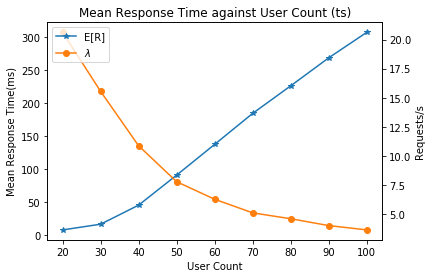

<Figure size 432x288 with 0 Axes>

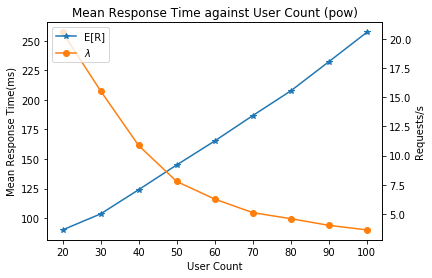

<Figure size 432x288 with 0 Axes>

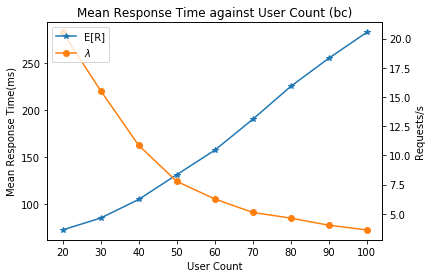

In [139]:
filename = 'data/locustdata.xlsx'
tasks = ['prepareTransfer', 'sendTrytes','sendTransfer', 'ts', 'pow', 'bc']
for sheet_name in tasks:
    locust = ProcLocustData(filename,sheet_name)
    locust.plotER()

In [ ]:
locust = ProcLocustData(filename,tasks[2])
locust.load2DF()

,Timestamp,Requests/s,Failures/s,0.5,0.66,0.75,0.8,0.9,0.95,0.98,...,0.999,0.9999,1,Total Request Count,Total Failure Count,Total Median Response Time,Total Average Response Time,Total Min Response Time,Total Max Response Time,Total Average Content Size
User Count,,,,,,,,,,,,,,,,,,,,,
20,1.617749e+09,1.179105,0.0,1451.724138,1503.448276,1540.517241,1603.448276,1737.931034,1795.689655,1821.551724,...,1872.413793,1872.413793,1872.413793,75.318966,0.0,1436.206897,1445.433215,1035.000000,1865.172414,232.0
30,1.617749e+09,3.115126,0.0,1434.453782,1509.243697,1664.705882,1742.016807,1924.369748,2126.050420,2410.084034,...,2940.336134,2940.336134,2940.336134,339.596639,0.0,1429.411765,1487.944296,857.554622,2915.058824,232.0
40,1.617749e+09,4.476471,0.0,1473.949580,1684.033613,1873.949580,1975.630252,2296.638655,2697.478992,3210.084034,...,5005.882353,5005.882353,5005.882353,797.689076,0.0,1473.949580,1612.214969,845.000000,4982.647059,232.0
50,1.617749e+09,5.240678,0.0,1588.983051,1932.203390,2138.135593,2305.084746,2865.254237,3421.186441,4162.711864,...,6405.932203,6774.576271,6774.576271,1421.991525,0.0,1588.135593,1823.927767,845.000000,6756.949153,232.0
60,1.617750e+09,5.331092,0.0,1775.630252,2117.647059,2431.092437,2664.705882,3416.806723,4138.655462,5039.495798,...,7448.739496,7900.840336,7900.840336,2027.193277,0.0,1775.630252,2044.279819,845.000000,7889.470588,232.0
70,1.617750e+09,5.807759,0.0,1949.137931,2433.620690,2831.034483,3154.310345,4111.206897,5030.172414,6125.862069,...,8582.758621,10780.172414,10780.172414,2709.603448,0.0,1949.137931,2323.146590,845.000000,10734.318966,232.0
80,1.617750e+09,5.576068,0.0,2100.854701,2741.025641,3275.213675,3647.008547,4789.743590,5809.401709,7077.777778,...,11907.692308,13000.000000,13000.000000,3383.692308,0.0,2100.854701,2609.332156,845.000000,12984.846154,232.0
90,1.617750e+09,5.569492,0.0,2355.084746,3108.474576,3726.271186,4188.135593,5442.372881,6629.661017,7861.864407,...,12000.000000,13000.000000,13000.000000,4068.872881,0.0,2354.237288,2903.058143,845.000000,13020.000000,232.0
100,1.617750e+09,6.038793,0.0,2595.689655,3487.068966,4197.413793,4706.034483,6162.931034,7471.551724,8904.310345,...,12017.241379,13293.103448,13293.103448,4773.120690,0.0,2594.827586,3209.071824,845.000000,13369.741379,232.0
